# 02 - Preparación de datos y creación de ventanas para LSTM


In [32]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [33]:
ruta = "../data/raw/continuous_dataset.csv"

df = pd.read_csv(
    ruta,
    parse_dates=['datetime'],
    index_col='datetime'
).sort_index()


In [34]:
df['hour'] = df.index.hour
df['dayofweek'] = df.index.day_of_week
df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)

feature_cols = [
    'nat_demand',
    'T2M_toc', 'T2M_san', 'T2M_dav',
    'hour', 'dayofweek', 'is_weekend',
    'holiday', 'school'
]

target_col = 'nat_demand'

df_model = df[feature_cols].copy()
df_model.head()

,nat_demand,T2M_toc,T2M_san,T2M_dav,hour,dayofweek,is_weekend,holiday,school
datetime,,,,,,,,,
2015-01-03 01:00:00,970.3450,25.865259,23.482446,22.662134,1,5,1,0,0
2015-01-03 02:00:00,912.1755,25.899255,23.399255,22.578943,2,5,1,0,0
2015-01-03 03:00:00,900.2688,25.937280,23.343530,22.531030,3,5,1,0,0
2015-01-03 04:00:00,889.9538,25.957544,23.238794,22.512231,4,5,1,0,0
2015-01-03 05:00:00,893.6865,25.973840,23.075403,22.481653,5,5,1,0,0


In [35]:
n = len(df_model)
train_size = int(n * 0.8)

df_train = df_model.iloc[:train_size]
df_test  = df_model.iloc[train_size:]

print("Train:", df_train.index.min(), "→", df_train.index.max(), "| filas:", len(df_train))
print("Test: ", df_test.index.min(), "→", df_test.index.max(),  "| filas:", len(df_test))

Train: 2015-01-03 01:00:00 → 2019-05-23 14:00:00 | filas: 38438
Test:  2019-05-23 15:00:00 → 2020-06-27 00:00:00 | filas: 9610


#### Scalado

In [36]:
X_train = df_train[feature_cols].values
y_train = df_train[[target_col]].values   # doble [] -> 2D

X_test  = df_test[feature_cols].values
y_test  = df_test[[target_col]].values

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)   # fit SOLO en train
y_train_scaled = scaler_y.fit_transform(y_train)

X_test_scaled  = scaler_X.transform(X_test)        # usamos los mismos params
y_test_scaled  = scaler_y.transform(y_test)

print(X_train_scaled.shape, y_train_scaled.shape, X_test_scaled.shape, y_test_scaled.shape)

(38438, 9) (38438, 1) (9610, 9) (9610, 1)


In [37]:
def create_sequences(X, y, seq_len):
    Xs, ys = [], []
    for i in range(seq_len, len(X)):
        Xs.append(X[i-seq_len:i])  # [t-seq_len, ..., t-1]
        ys.append(y[i])            # valor en t
    return np.array(Xs), np.array(ys)


In [38]:
sequence_length = 24 * 7  # 7 días de historia (168 horas)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, sequence_length)
X_test_seq,  y_test_seq  = create_sequences(X_test_scaled,  y_test_scaled,  sequence_length)

print("X_train_seq:", X_train_seq.shape)
print("y_train_seq:", y_train_seq.shape)
print("X_test_seq :", X_test_seq.shape)
print("y_test_seq :", y_test_seq.shape)

X_train_seq: (38270, 168, 9)
y_train_seq: (38270, 1)
X_test_seq : (9442, 168, 9)
y_test_seq : (9442, 1)


In [39]:
import torch
from torch.utils.data import TensorDataset, DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Usando device:", device)

X_train_tensor = torch.tensor(X_train_seq, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_seq, dtype=torch.float32).to(device)

X_test_tensor  = torch.tensor(X_test_seq,  dtype=torch.float32).to(device)
y_test_tensor  = torch.tensor(y_test_seq,  dtype=torch.float32).to(device)

X_train_tensor.shape, y_train_tensor.shape


Usando device: cuda


(torch.Size([38270, 168, 9]), torch.Size([38270, 1]))

In [40]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)


In [41]:
for X_batch, y_batch in train_loader:
    print(X_batch.shape, y_batch.shape)
    break
print(len(train_loader))

torch.Size([64, 168, 9]) torch.Size([64, 1])
598


In [42]:
import torch.nn as nn 

class LSTMForecast(nn.Module): 
    def __init__(self, input_size, hidden_size=64, num_layers=2, output_size=1):
        super().__init__()
        # Capa de LSTM
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        # Capa lineal final 
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        # x: (batch_size, seq_len, input_size)
        out, _ = self.lstm(x)

        last_hidden = out[:, -1, :]
        out = self.fc(last_hidden)
        return out
        

Tengo un batch de 64 ventanas.
Cada ventana representa 7 días (168 horas) y, en cada hora, tengo 9 features.

El LSTM es un solo modelo (no 64 distintos) que procesa las 64 ventanas en paralelo.
Si hago zoom en una sola ventana:

el LSTM recorre las 168 horas en orden temporal,

en cada paso ve un vector de 9 features (esa hora) y actualiza un estado interno (hidden) de tamaño 64,

al terminar la hora 168, me quedo con el último hidden, que es un resumen de lo que pasó en esas 168 horas.

Ese vector de tamaño 64 lo paso por una capa final (fc) para obtener una predicción de la demanda en la hora siguiente.

Esto mismo pasa para las 64 ventanas del batch en paralelo, así que obtengo 64 predicciones.
Comparo esas 64 predicciones con los 64 valores reales (y_batch), calculo la pérdida (por ejemplo el MSE promedio) y con eso ajusto los pesos del LSTM y de la capa final para que la próxima vez prediga mejor.

In [43]:
input_size = X_train_seq.shape[2]

model = LSTMForecast(input_size).to(device)

model

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(model)


LSTMForecast(
  (lstm): LSTM(9, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [44]:
n_epochs = 15

for epoch in range(n_epochs):
    #train
    model.train()
    train_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad() # limpiar gradientes anteriores
        y_pred = model(X_batch) # forward: LSTM + fc
        loss = criterion(y_pred, y_batch) # MSE entre preds y targets
        loss.backward() # backprop: calcula gradientes
        optimizer.step() # actualiza pesos del modelo

        train_loss += loss.item() * X_batch.size(0)

    train_loss /= len(train_loader.dataset)
        
    all_pred = []
    # Validation 
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            
            all_pred.append(y_pred)
    all_pred = torch.cat(all_pred, dim=0)
    all_pred = all_pred.cpu().numpy()
    

    val_loss /= len(test_loader.dataset)

    print(f"Epoch {epoch+1}: train_loss={train_loss:.6f}, val_loss={val_loss:.6f}")

Epoch 1: train_loss=0.006675, val_loss=0.002277
Epoch 2: train_loss=0.000944, val_loss=0.001685
Epoch 3: train_loss=0.000723, val_loss=0.001486
Epoch 4: train_loss=0.000575, val_loss=0.001246
Epoch 5: train_loss=0.000417, val_loss=0.000816
Epoch 6: train_loss=0.000354, val_loss=0.000805
Epoch 7: train_loss=0.000296, val_loss=0.000582
Epoch 8: train_loss=0.000261, val_loss=0.000480
Epoch 9: train_loss=0.000247, val_loss=0.000432
Epoch 10: train_loss=0.000233, val_loss=0.000354
Epoch 11: train_loss=0.000212, val_loss=0.000365
Epoch 12: train_loss=0.000204, val_loss=0.000481
Epoch 13: train_loss=0.000206, val_loss=0.000320
Epoch 14: train_loss=0.000199, val_loss=0.000337
Epoch 15: train_loss=0.000192, val_loss=0.000306


In [45]:
y_test_true = scaler_y.inverse_transform(y_test_seq)
y_test_pred  = scaler_y.inverse_transform(all_pred)
y_test_pred.shape, y_test_true.shape

((9442, 1), (9442, 1))

### Calculo de metrica

In [46]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test_pred, y_test_true)
mae = mean_absolute_error(y_test_pred, y_test_true)

rmse = mse ** 0.5 

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}") # Esta en la misma unidad que el target y no al cuadrado como MSE 


MAE: 20.58
MSE: 816.71
RMSE: 28.58


#### Graficamos

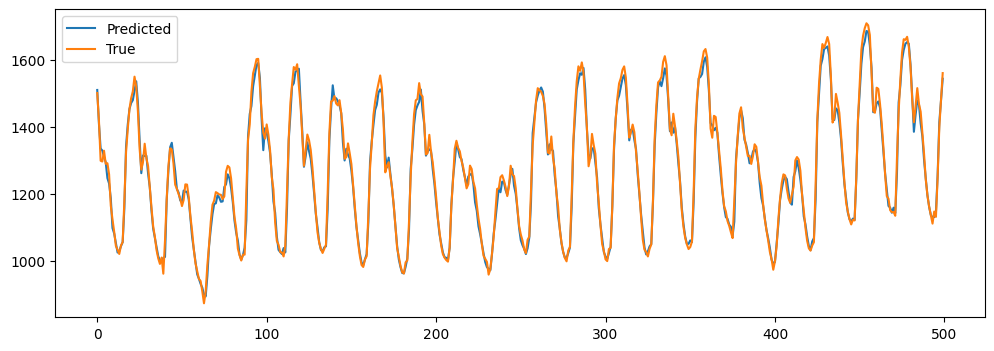

In [47]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.plot(y_test_pred[:500], label='Predicted')
plt.plot(y_test_true[:500], label='True')
plt.legend()
plt.show()

### Forecast recursivo multi-step

In [48]:
model.eval()

sequence_length = X_test_seq.shape[1]
n_features = X_test_seq.shape[2]

def recursive_forecast_from_test(start_seq_idx, horizon=24):
    """
    Hace un multi-step forecast recursivo desde la ventana X_test_seq[start_seq_idx].
    Devuelve las predicciones en escala [0,1].
    IMPORTANTE: usa X_test_scaled para las otras features futuras (best-case, clima perfecto).
    """
    window = X_test_seq[start_seq_idx].copy()  #Numero de la ventana que quiero que me devuelva (168,9)
    preds_val = []
    with torch.no_grad():
        for step in range(horizon):
            # Usar la ventana actual para predecir
            x_tensor = torch.tensor(window, dtype=torch.float32).unsqueeze(0).to(device)
            y_pred = model(x_tensor)
            y_pred_val = y_pred.item()
            preds_val.append(y_pred_val)
            
            # Construir la siguiente ventana
            next_window = np.zeros_like(window)
            next_window[:-1,:] = window[1:,:]

            #Ponemos en la ÚLTIMA fila
            t_index = start_seq_idx + sequence_length + step
            future_feat = X_test_scaled[t_index].copy()
            future_feat[0] = y_pred_val
            next_window[-1,:] = future_feat

            window = next_window
    preds_val = np.array(preds_val)
    return preds_val

In [71]:
start_seq_idx = 0
horizon = 48
preds_val_scaled = recursive_forecast_from_test(start_seq_idx, horizon)

preds_val = scaler_y.inverse_transform(preds_val_scaled.reshape(-1,1))

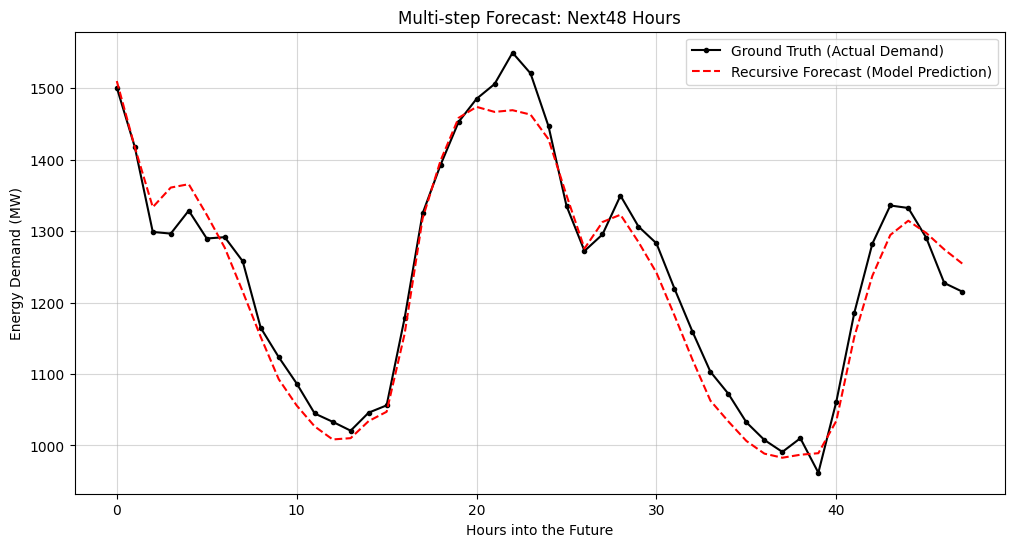

In [72]:
# Extraer los valores REALES para ese mismo periodo
indice_real_inicio = start_seq_idx + sequence_length
y_true_scaled = y_test_scaled[indice_real_inicio : indice_real_inicio + horizon]
y_true = scaler_y.inverse_transform(y_true_scaled)

# Visualizamos 
plt.figure(figsize=(12, 6))
plt.plot(y_true,label='Ground Truth (Actual Demand)', marker='.', color='black')
plt.plot(preds_val,label='Recursive Forecast (Model Prediction)', color='red', linestyle='--')
plt.title(f'Multi-step Forecast: Next{horizon} Hours')
plt.ylabel('Energy Demand (MW)')
plt.xlabel('Hours into the Future')
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()